### Последовательности событий и классические временные ряды в нейронных сетях

#### Классический временной ряд
В основном данные синхронны, с одинаковой задержкой

Данные могут быть представлены в виде последовательности значений $\{\mathbf{x}_i\}_{i=1}^N$I c заданным временным лагом $\Delta t$.

Нейронные сети:
- Рекуррентные нейронные сети (RNN, LSTM, GRU)
    
     Плюсы:
    
     - Улавливают временные зависимости
    
     Минусы:
    
     - Стремление поймать долгосрочные зависимости
     - Борьба с исчезновением градиента
     - Не могут быть распараллеленны

- CNN для временных рядов
    
     Плюсы:
    
     - Могут быть распараллеленны
     - Лучше фиксирует долгосрочные зависимости
    
     Минусы:
    
     - Принудительно применяют ненужные зависимости

- Трансформеры
    
     Плюсы:
    
     - Могут быть распараллеленны
     - Изучают внутренние зависимости с помощью механизма внимания

#### Последовательности событий
Данные асинхронны, неодинаково запаздывают

Данные могут быть представлены в виде последовательности пар $\{(t_i,c_i)\}_{i=1}^N$, временной лаг предусмотреть нельзя и нужно учитывать время прихода.

Нейронные сети:

Должно быть похоже, однако, как можно учитывать неравные лаги?

### Общий порядок обучения

Предположим, что мы успешно построили некоторую модель $model(\mathbf{s}) \to \lambda(t|\mathcal{H})$. Как мы можем ее тренировать?

Отрицательная логарифмическая вероятность:
$$
\mathcal{L} = -\sum_{n=1}^N\left(\sum_{i=1}^{L_n}\log \lambda_{i}^n - \int_{0}^{T_n}\lambda(t | \mathcal {H} _n) \right)
$$

Наша цель - минимизировать потери.

Что делать с интегралом?
- Интеграция Монте-Карло
   $$
  \hat{\Lambda}_{MC} = \sum_{j=2}^L(t_j - t_{j-1})\left(\frac{1}{N}\sum_{i=1}^N \lambda(u_i)\right), ~ u_i \sim Unif(t_{j-1},t_j)
  $$
- Трапециевидная интеграция
   $$
   \hat{\Lambda}_{TR} = \sum_{j=2}^L\frac{t_j - t_{j-1}}{2}\left(\lambda(t_j|\mathcal{H}_{t_j}) + \lambda(t_{j-1}|\mathcal{H}_{t_{j-1}})\right)
   $$

Интеграция по методу Монте-Карло будет более точной, но займет больше времени из-за дополнительной выборки.

Теперь у нас есть целевая функция.

Мы должны разработать модель.

### Нейронный процесса Хоукса

https://www.researchgate.net/publication/312022942_The_Neural_Hawkes_Process_A_Neurally_Self-Modulating_Multivariate_Point_Process

Эта работа была вдохновлена моделью LSTM. Модель LSTM оказалась хорошим выбором для прогнозирования временных рядов.

**Вопрос:**
Как мы можем применить LSTM к последовательностям событий?

Основная проблема здесь в том, что LSTM был разработан для данных с равной задержкой.
В статье авторы предложили добавить эволюцию скрытых и клеточных состояний между событиями.

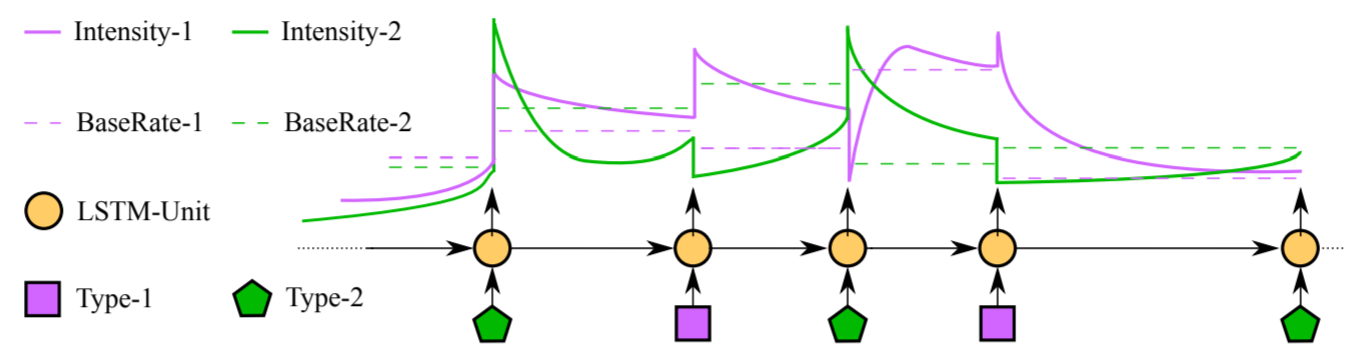

Интенсивности можно найти со скрытым состоянием, используя следующую формулу:
$$\lambda_k(t) = f_k(\mathbf{w}_k^\top \mathbf{h}(t)), ~ f_k(u) = s_k \log(1 + \exp(u/s_k))$$

Здесь k — тип события, а $f_k$ гарантирует, что результат будет больше нуля.

Архитектура LSTM аналогична исходной архитектуре LSTM, поэтому мы не будем на ней сосредотачиваться.


Давайте изучим, как именно устроена эволюция между событиями.

- Скрытое состояние зависит от состояния ячейки $\mathbf{h}(t) = \mathbf{o}_i \odot ( 2\sigma(2\mathbf{c}(t)) - 1)$
- Состояния ячеек эволюционируют в некоторое базовое состояние ячейки $\mathbf{c}(t) = \overline{\mathbf{c}}_{i+1} + (\mathbf{c}_{i+1} - \overline {\mathbf{c}}_{i+1})\exp(-\boldsymbol{\delta}_{i+1}(tt_i))$
- Если мы забудем о нелинейностях, окажется, что мы используем показатели степени в качестве базисных функций.
- Нелинейности позволяют добиться более сложного поведения
- Мы можем предсказать волнения, возбуждения и их комбинации

Посмотрим на функци. интенсивности:

$$\lambda_k(t) = g(\{(c_{i+1}^j - \overline{c}_{i+1}^j)\exp(-\delta_{i+1}^j(t-t_i)\}_{j=1}^{hidden\_size})$$

Здесь $g$ — функция, объединяющая все функции $\lambda_k$. Это позволяет нам прогнозировать огромное разнообразие моделей поведения.

- Плюсы
     - Моделирует функцию интенсивности везде
     - Учитывает неравные временные задержки
- Минусы
    
     - То же, что и для классического LSTM

### Трансформер Хоукса

https://arxiv.org/pdf/2002.09291.pdf

- Трансформер - это современное решение для задач seq2seq.
- Трансформеры могут эффективно улавливать долгосрочные зависимости
- Трансформаторы могут быть параллельны
- Они не предназначены для временных точечных процессов...

Можно использовать эмбеддинги для типов событий, и оно будет работать с преобразователями. Но что нам делать со временем прибытия?

**Solution**

Временное кодирование $(i\in\{1,\dots,M\})$

$$
[\mathbf{z}(t_j)]_i = \begin{cases}cos(t_j/10000^{\frac{i-1}{M}}), ~ \text{if} ~ i~\text{is odd}\\sin(t_j/10000^{i/M}), ~ \text{if} ~ i~\text{is even}\end{cases}
$$

Кодирование событий

$$
\mathbf{e}_j = \mathbf{U}\mathbf{c}_j
$$

$\mathbf{c}_j$ is an event one-hot encoding, $\mathbf{U}\in\mathbb{R}^{M\times C}$. $\mathbf{C} = [\mathbf{c}_1,\dots,\mathbf{c}_L]\in\mathbb{R}^{K\times L}$

Вход трансформатора будет следующим:

$$
\mathbf{X} = (\mathbf{U}\mathbf{C} + \mathbf{Z})^{\top}
$$


**Архитектура**

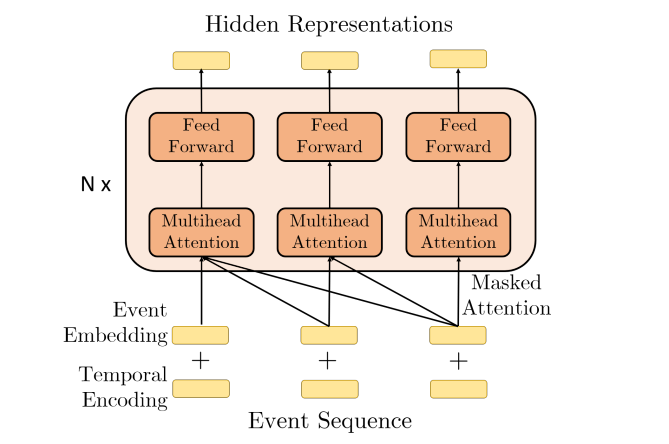

**Напоминание**
    
Механизм внимания:
    
$$
    \mathbf{S} = \mathrm{Softmax}\left(\frac{\mathbf{Q}\mathbf{K}^{\top}}{\sqrt{M_K}}\right)\mathbf{V}
$$
    
$$
    \mathbf{Q} = \mathbf{X}\mathbf{W}^Q,~\mathbf{K} =\mathbf{X}\mathbf{W}^K,~\mathbf{V}=\mathbf{X}\mathbf{W}^V
$$
    
$$
    \mathbf{W}^Q,\mathbf{W}^K\in\mathbb{R}^{M\times M_{K}},~\mathbf{W}^V\in \mathbb{R}^{M\times M_V}
$$
    
Multihead Attention: $\mathbf{S}_1,\dots,\mathbf{S}_H$.
    
Выход мезанизма внимания:
    
$$
    \mathbf{S} = [\mathbf{S}_1,\dots,\mathbf{S}_H]\mathbf{W}^O, ~ \mathbf{W}^O\in\mathbb{R}^{HM_V\times M}
$$
    
За механизмом вниманя следует нейронная сеть с прямой связью по положению, состоящая из двух линейных слоев. Результирующая матрица$\mathbf{H}\in\mathbb{R}^{L\times M}$.
    
Авторы избегают заглядывания в будущее, используя маскированное внимание.

Теперь, когда мы успешно внедрили модель трансформатора, которая может обрабатывать последовательности событий, как мы можем предсказать интенсивность?

В статье авторы предложили следующее решение:

$$
\lambda_k(t|\mathcal{H}_t) = f_k\left(\alpha_k\frac{t-t_j}{t_j} + \mathbf{w}_k^{\top}\mathbf{h}(t_j) + b_k\right),~t\in[t_j,t_{j+1})\\f_k(u) = s_k\log(1+\exp(u/s_k))
$$

Условия:

- $\alpha_k\frac{t-t_j}{t_j}$ - интерполяция текущего влияния между наблюдаемыми временными метками $t_j$ и $t_{j+1}$
- $\mathbf{w}_k^{\top}\mathbf{h}(t_j)$ - исторический термин
- $b_k$ - базовая интенсивность

Учитывая эту интенсивность, можно найти ожидаемое время прибытия и тип события следующим образом:

$$
p(t|\mathcal{H}_t) = \lambda(t|\mathcal{H}_t)\exp\left(-\int_{t_j}^t\lambda(\tau|\mathcal{H}_{\tau})d\tau\right)\\\hat{t}_{j+1} = \int_{t_j}^{+\infty}tp(t|\mathcal{H}_t)dt\\ \hat{c}_{j+1} = \arg\max_c \frac{\lambda_c(t_{j+1}|\mathcal{H}_{j+1})}{\lambda(t_{j+1}|\mathcal{H}_{j+1})}
$$

### Обучающий пример

#### Генерация набора данных

Давайте создадим набор данных только с одним типом события.

In [ ]:
import torch

class Hawkes:
  def __init__(self, mu, a, delta):
    self.mu = mu
    self.a = a
    self.delta = delta

  def intensity(self, t, seq, in_point =  False):
    """
    Returns intensity function in the momemt of time t given the sequence
    If in_point is true change the inequality from t_i < t to t_i <= t, this will be useful for sequence generation
    """
    # code here
    if len(seq) > 0:
      delta_t = t - seq
      if not in_point:
        delta_t = delta_t[delta_t > 0]
      else:
        delta_t = delta_t[delta_t >= 0]
      return self.mu + torch.sum(self.a * torch.exp(- self.delta * delta_t))
    else:
      return self.mu

  def generate_next_point(self, seq):
    """
    Generates the next event in the sequence
    """
    # code here, you can use the code from the previous seminar for Nonhomogeneous Poisson
    starting_time = 0
    N = len(seq)
    while len(seq) == N:
      if N > 0:
        lambda_hat = self.intensity(seq[-1] + starting_time, seq, True)
      else:
        lambda_hat = self.mu
      T = 100 * 1/lambda_hat
      poisson_lambda = lambda_hat * T

      N_hat = torch.poisson(torch.Tensor([poisson_lambda])).long()[0]
      auxiliar_seq, _ = torch.sort(torch.rand((N_hat,)) * T)
      if N > 0:
        auxiliar_seq += starting_time + seq[-1]
      else:
        auxiliar_seq += starting_time

      probas = torch.Tensor([self.intensity(t, seq) for t in auxiliar_seq])/lambda_hat
      indices = (probas > torch.rand((N_hat,)))

      next_seq = auxiliar_seq[indices]

      if len(next_seq) == 0:
        starting_time += T
      else:
        seq = torch.concat([seq, torch.Tensor([next_seq[0]])])

    return seq

  def generate_sequence(self, max_time = None, max_jumps = None):
    """
    Generates one Hawkes Process sequence, limits the sequence with either max_jumps or max_time
    """
    if (max_time is None) and (max_jumps is None):
      raise Exception("Either max_time or max_jumps have to be provided")

    # code here
    seq = torch.Tensor([])

    seq = self.generate_next_point(seq)

    while True:
      if max_time is not None:
        if seq[-1] > max_time:
          break
      if max_jumps is not None:
        if len(seq) > max_jumps:
          break

      seq = self.generate_next_point(seq)

    seq = seq[:-1]
    return seq


In [ ]:
import tqdm

seed = 42
N = 1000

mu = 1.0
a = 0.35
delta = 0.7

torch.manual_seed(seed)

model = Hawkes(mu, a, delta)
dataset = [model.generate_sequence(max_jumps = 100) for i in tqdm.tqdm(range(N))]

100%|██████████| 1000/1000 [10:19<00:00,  1.61it/s]


In [ ]:
dataset = torch.vstack(dataset)

In [ ]:
dataset.shape

torch.Size([1000, 100])

In [ ]:
dataset[0]

tensor([ 0.4062,  0.5986,  1.0175,  1.4854,  1.7008,  2.1421,  3.8565,  4.0801,
         5.0479,  5.2951,  5.4870,  6.2796,  7.5522,  7.8870, 10.2985, 10.9808,
        12.0762, 13.1100, 15.3516, 15.7684, 16.0845, 16.8279, 17.7247, 18.2505,
        18.9932, 19.5824, 19.9457, 22.0854, 22.6008, 23.6018, 23.7801, 24.8093,
        25.0384, 25.5723, 26.2714, 26.6090, 27.2119, 27.8750, 28.4265, 28.5473,
        28.9120, 29.9322, 30.2323, 33.2716, 33.8462, 34.3814, 35.2758, 35.2892,
        35.4071, 35.4792, 35.6551, 35.8517, 36.1443, 36.4270, 36.4808, 36.6886,
        36.7331, 36.9780, 37.1344, 37.2439, 37.3268, 37.3961, 37.5283, 38.6681,
        39.0927, 39.1675, 39.1770, 41.6512, 43.2759, 43.5053, 43.5406, 44.1248,
        44.3450, 44.4665, 46.2005, 47.4015, 47.5317, 48.3862, 49.0678, 49.1613,
        49.5355, 50.7786, 51.3075, 52.6951, 53.4576, 53.8352, 54.2374, 54.3051,
        54.5956, 54.7860, 54.7938, 55.0648, 55.4100, 55.6590, 55.7603, 56.0257,
        57.1403, 58.0243, 60.7103, 61.28

#### Обучение классической модели Хоукса

Чтобы найти параметры процесса Хоукса нам нужно минимизировать следующее отрицательное правдоподобие:
$$
Loss = - \sum_{i=1}^{N}\left(\sum_{j=1}^{L}\log\lambda(t_{i,j}) -\int_{0}^{t_{i,L}}\lambda(u)du\right)
$$

В основном данная задача решается с использованием методов максимизации матожидания или же с помощью SGD.

Работы:
- Xu, Hongteng & Chen, Xu & Carin, Lawrence. (2018). Superposition-Assisted Stochastic Optimization for Hawkes Processes.
- Joseph, Sobin & Kashyap, Lekhapriya & Jain, Shashi. (2020). Shallow Neural Hawkes: Non-parametric kernel estimation for Hawkes processes.
- Zhang, Rui & Walder, Christian & Rizoiu, Marian-Andrei & Xie, Lexing. (2018). Efficient Non-parametric Bayesian Hawkes Processes.

Для простоты давайте решать данную задачу для постоянной базовой интенсивность, экспоненциальных ядер и использовать SGD оптимизацию для данной параметрической формы. Мы будем использовать ```torch.nn.Module``` для того, чтобы использовать все преимущества torch моделей.

##### Задача: Перепишите функцию потери в форме, которая удобна для вычислений на бэтчах.

*Note: Предполагайте, что все последовательности одной длины, а интенсивность имеет вид $\lambda(t|\mathcal{H}) = \mu + \sum_{i: t_i<t}a\exp(-\delta (t-t_i))$*

Пусть $\mathbf{s}$ последовательность событий, $\mathbf{s} = \{t_i\}_{i=1}^L$. Давайте введем матрицу:
$$
\mathbf{S}_{i,j} = t_i - t_j
$$

С учетом $\mathbf{s}$ давайте найдем $\sum_{i} \log \lambda(t_i)$. Дано $\lambda^*(t) = \mu + \sum_{i: t_i < t} a \exp(-\delta (t -t_j))$.

Пусть
$$
\mathbf{V} = \begin{pmatrix}
                    0 & 0 & 0 &\cdots & 0 \\
                    1 & 0 & 0 &\cdots & 0 \\
                    1 & 1 & 0 &\cdots & 0 \\
                    \vdots & \vdots & \vdots & \ddots & \vdots \\
                    1 & 1 & 1 & \cdots & 0\end{pmatrix} \in \mathbb{R}^{L \times L}
$$

Тогда можно найти интенсивность следующим образом:
$$
\lambda(t_i) = \mu + \sum_{j} \left[\exp\left(-\delta \mathbf{S}\right) \odot (aV)\right]_{ij}
$$

Здесь $\exp$ применяется поэлементно, $\odot$ - поэлементное перемножение.

Давайте найдем интеграл.

$$
\lambda(t) = \mu + \sum_{i: t_i < t} a\exp(-\delta(t-t_i)) = \mu + \sum_{i}a\exp(-\delta(t-t_i))\theta(t-t_i)
$$

Здесь $\theta$ функция Хевисайда, поэтому $\theta(x) = \begin{cases}1, ~ \text{if}~x>0\\0, ~\text{else}\end{cases}$.
$$
\int_{0}^{t_L}\lambda(t)dt = \mu t_L - \sum_{i}\frac{a}{\delta}\exp(-\delta(t - t_i))\big{|}_{t_i}^{t_L} = \mu t_L + \sum_{i}\frac{a}{\delta}(1 - \exp(-\delta(t_L - t_i)))
$$

Затем мы можем подставить данные формулы в правдоподобие.

##### Задача: Допишите недостающее.

Давайте напишем класс процесса Хоукса

In [ ]:
class HawkesModel(torch.nn.Module):
  def __init__(self, L, init_mu = 0.1, init_a = 0.1, init_delta = 0.1):
    super().__init__()
    self.mu = torch.nn.Parameter(init_mu*torch.ones(1))
    self.a = torch.nn.Parameter(init_a*torch.ones(1))
    self.delta = torch.nn.Parameter(init_delta*torch.ones(1))
    self.L = L
    # code here
    self.V = torch.tril(torch.ones((L,L))) - torch.eye(L)
    self.V = self.V.unsqueeze(0)

  def forward(self, batch):
    """
    Returns loss
    Note: ideally it should predict next arrival time, however we need only to prove the concept, so no need to implement this right now
    """
    # events
    lambda_loss = - torch.sum(torch.log(self.lambdas(batch)))

    # non events
    integral_loss = self.integral(batch)

    return lambda_loss + integral_loss

  def lambdas(self, batch):
    """Returns lambda(t_{i,j}) for all i, j (do not sum, we will use this function later)"""
    # code here

  def integral(self, batch):
    """Returns integral loss (do not forget to sum)"""
    # code here

  def __str__(self):
    return "lambda = {:.3f} + sum {:.3f} * exp( - {:.3f} (t - t_i))".format(self.mu.detach().numpy()[0], self.a.detach().numpy()[0], self.delta.detach().numpy()[0])

###### Lambdas

In [ ]:
class HawkesModel(torch.nn.Module):
  def __init__(self, L, init_mu = 0.1, init_a = 0.1, init_delta = 0.1):
    super().__init__()
    self.mu = torch.nn.Parameter(init_mu*torch.ones(1))
    self.a = torch.nn.Parameter(init_a*torch.ones(1))
    self.delta = torch.nn.Parameter(init_delta*torch.ones(1))
    self.L = L
    # code here
    self.V = torch.tril(torch.ones((L,L))) - torch.eye(L)
    self.V = self.V.unsqueeze(0)

  def forward(self, batch):
    """
    Returns loss
    Note: ideally it should predict next arrival time, however we need only to prove the concept, so no need to implement this right now
    """
    # events
    lambda_loss = - torch.sum(torch.log(self.lambdas(batch)))

    # non events
    integral_loss = self.integral(batch)

    return lambda_loss + integral_loss

  def lambdas(self, batch):
    """Returns lambda(t_{i,j}) for all i, j (do not sum, we will use this function later)"""
    # code here
    S = batch.unsqueeze(2).repeat(1,1,self.L)
    S = S - S.transpose(1,2)
    lambdas = self.mu + torch.sum(torch.exp(-self.delta * S) * (self.a * self.V), dim = 2)
    return lambdas

  def integral(self, batch):
    """Returns integral loss (do not forget to sum)"""
    # code here

  def __str__(self):
    return "lambda = {:.3f} + sum {:.3f} * exp( - {:.3f} (t - t_i))".format(self.mu.detach().numpy()[0], self.a.detach().numpy()[0], self.delta.detach().numpy()[0])

###### Integral

In [14]:
import torch

class HawkesModel(torch.nn.Module):
  def __init__(self, L, init_mu = 0.1, init_a = 0.1, init_delta = 0.1):
    super().__init__()
    self.mu = torch.nn.Parameter(init_mu*torch.ones(1))
    self.a = torch.nn.Parameter(init_a*torch.ones(1))
    self.delta = torch.nn.Parameter(init_delta*torch.ones(1))
    self.L = L
    # code here
    self.V = torch.tril(torch.ones((L,L))) - torch.eye(L)
    self.V = self.V.unsqueeze(0)

  def forward(self, batch):
    """
    Returns loss
    Note: ideally it should predict next arrival time, however we need only to prove the concept, so no need to implement this right now
    """
    # events
    lambda_loss = - torch.sum(torch.log(self.lambdas(batch)))

    # non events
    integral_loss = self.integral(batch)

    return lambda_loss + integral_loss

  def lambdas(self, batch):
    """Returns lambda(t_{i,j}) for all i, j (do not sum, we will use this function later)"""
    # code here
    S = batch.unsqueeze(2).repeat(1,1,self.L)
    S = S - S.transpose(1,2)
    lambdas = self.mu + torch.sum(torch.exp(-self.delta * S) * (self.a * self.V), dim = 2)
    return lambdas

  def integral(self, batch):
    """Returns integral loss (do not forget to sum)"""
    # code here
    base = self.mu * batch[:, -1]
    last = batch[:,-1].unsqueeze(1).repeat(1,self.L)
    exps = (self.a - self.a * torch.exp(-self.delta * (last - batch)))/self.delta

    integral_loss = torch.sum(base) + torch.sum(exps)
    return integral_loss

  def __str__(self):
    return "lambda = {:.3f} + sum {:.3f} * exp( - {:.3f} (t - t_i))".format(self.mu.detach().numpy()[0], self.a.detach().numpy()[0], self.delta.detach().numpy()[0])

##### Тренировка

Мы будем тренировать с помощью градиетного спуска, давайте напишем тренировочную функцию.

In [15]:
import numpy as np

def train(model, ref_model, train_loader, optimizer, epoch):
    model.train()
    ll = []
    mse_lambdas = []
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        lambdas = model.lambdas(batch)
        ref_lambdas = ref_model.lambdas(batch)
        mse_lambdas.append(torch.mean((lambdas - ref_lambdas)**2).item())
        negative_ll = model(batch)
        negative_ll.backward()
        optimizer.step()
        ll.append(negative_ll.item())
    return np.mean(ll), np.mean(mse_lambdas)

Давайте запустим тренировку. Будем строить графики для $\mu$, $a$ и $\delta$ и сравнивать предсказанную интенсивность с ожидаемой.

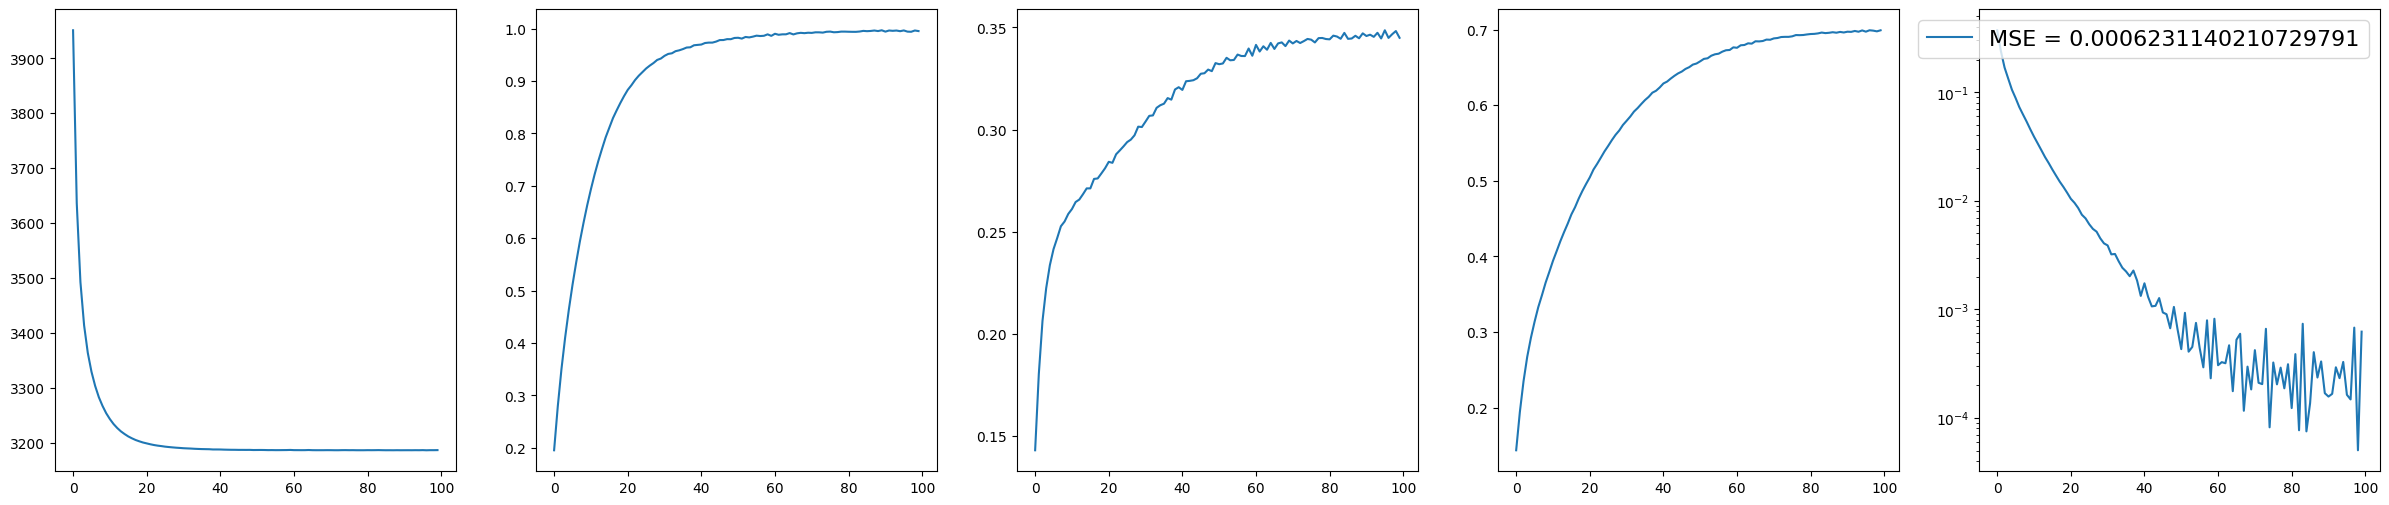

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

model = HawkesModel(100)
ref_model = HawkesModel(100, 1.0, 0.35, 0.7)
batch_size = 100

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, num_workers = 0, pin_memory = True, shuffle = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
losses = []
mu = []
a = []
delta = []
mse_lambdas = []

for epoch in range(100):
  clear_output(wait=True)
  l, m = train(model, ref_model, train_dataloader, optimizer, epoch)
  losses.append(l)
  mse_lambdas.append(m)
  mu.append(model.mu.detach().numpy()[0])
  a.append(model.a.detach().numpy()[0])
  delta.append(model.delta.detach().numpy()[0])
  fig, axes = plt.subplots(1, 5, figsize=(30,6))
  axes[0].plot(losses)
  axes[1].plot(mu)
  axes[2].plot(a)
  axes[3].plot(delta)
  axes[4].plot(mse_lambdas, label = "MSE = {}".format(m))
  axes[4].set_yscale('log')
  axes[4].legend(fontsize=16, loc="upper right", bbox_to_anchor=(1,1))
  plt.show()

#### Обучение трансформера

##### Single head attention

Давайте реализуем single head attention. Мы должны использовать замаскированное внимание, чтобы не заглядывать в будущее.

Мы будем использовать single head в качестве модели для простоты реализации. Действительно, мультихед лучше векторизовать.

Давайте реализуем:
```
class Attention(nn.Module):
  def __init__(self, M, M_K, M_V):
    super().__init__()
    self.M = M
    self.M_K = M_K
    self.M_V = M_V
```
Здесь `M` — размер встраивания, `M_K` — размеры запроса и ключа, а `M_V` — размер значения.

Соответствующие веса:
```
    self.W_Q = Parameter(nn.init.xavier_uniform_(torch.zeros(M,M_K)))
    self.W_K = Parameter(nn.init.xavier_uniform_(torch.zeros(M,M_K)))
    self.W_V = Parameter(nn.init.xavier_uniform_(torch.zeros(M,M_V)))
```

Теперь реализуем forward слой:
```
  def forward(self, X):
    bs, L, _ = X.shape
    Q = X @ self.W_Q
    K = X @ self.W_K
    V = X @ self.W_V

    pre_softmax = Q @ K.transpose(1,2) / self.M_K ** 0.5
```
Прежде чем применять softmax и вычислять оценки, мы должны замаскировать будущее. Мы будем использовать -torch.inf, который всегда будет возвращать 0 для softmax.
```
    mask = (torch.triu(torch.ones((L,L))) - torch.eye(L)).unsqueeze(0).repeat(bs,1,1)
    pre_softmax[mask == 1] = -torch.inf
    softmax = torch.softmax(pre_softmax, dim = 2)
    S = softmax @ V
    return S
```

In [17]:
from torch.nn import Parameter
import torch.nn as nn

class Attention(nn.Module):
  def __init__(self, M, M_K, M_V):
    super().__init__()
    self.M = M
    self.M_K = M_K
    self.M_V = M_V

    self.W_Q = Parameter(nn.init.xavier_uniform_(torch.zeros(M,M_K)))
    self.W_K = Parameter(nn.init.xavier_uniform_(torch.zeros(M,M_K)))
    self.W_V = Parameter(nn.init.xavier_uniform_(torch.zeros(M,M_V)))

  def forward(self, X):
    bs, L, _ = X.shape
    Q = X @ self.W_Q
    K = X @ self.W_K
    V = X @ self.W_V

    pre_softmax = Q @ K.transpose(1,2) / self.M_K ** 0.5
    mask = (torch.triu(torch.ones((L,L))) - torch.eye(L)).unsqueeze(0).repeat(bs,1,1)
    pre_softmax[mask == 1] = -torch.inf
    softmax = torch.softmax(pre_softmax, dim = 2)
    S = softmax @ V
    return S

##### Feed forward слой

Теперь давайте реализуем слой прямой связи, который следует использовать после внимания нескольких головок.

Это просто дополнительный слой, который состоит из двух полносвязных слоев и ReLU.

In [ ]:
class FeedForwardLayer(nn.Module):
  def __init__(self, M, M_H):
    super().__init__()
    self.layer_1 = nn.Linear(M, M_H)
    self.layer_2 = nn.Linear(M_H, M)
    self.relu = nn.ReLU()

  def forward(self, S):
    return self.layer_2(self.relu(self.layer_1(S)))

##### Модель Трансформера

###### Инициализация

Теперь давайте объединим все части в модель трансформера.

Мы рассмотрим одну модель преобразователя событийного типа.

Прежде всего мы должны инициализировать несколько головок внимания. Если хотите, можете векторизовать мультихед самостоятельно.

```
class TransformerHawkes(nn.Module):
  def __init__(self, M, M_K, M_V, M_H, num_of_attentions = 10):
    super().__init__()
    # transformer
    self.attentions = nn.ModuleList([Attention(M,M_K, M_V) for i in range(num_of_attentions)])
```

Затем мы должны вычислить результат подхода с multihead attention:
```
    self.W_O = Parameter(nn.init.xavier_uniform_(torch.zeros(num_of_attentions*M_V,M)))
```

После этого мы должны добавить слой прямой связи и окончательную нормализацию:
```
    self.feed_forward = FeedForwardLayer(M, M_H)
    self.layer_norm = nn.LayerNorm(M, eps=1e-6)
```

Мы должны ввести параметр для окончательных вычислений интенсивности, как вы помните, это $\alpha$, $\mathbf{w}$ и $b$.

```
    # intensity prediction
    self.alpha = Parameter(torch.ones(1))
    self.w  = Parameter(torch.rand(M))
    self.b = Parameter(torch.ones(1))
```

Вместо softplus мы будем использовать ReLU.
```
    self.relu = nn.ReLU()
```

###### Forward pass

Учитывая последовательности и моделируемое время, мы хотим вычислить лямбды и интеграл.

Прежде всего, мы должны подсчитать баллы:

```
def forward(self, X, times, N = 100):
    """
    Returns lambda(t_i) and lambda(u_i)
    Note: ideally it should predict next arrival time, however we need only to prove the concept, so no need to implement this right now
    """
    scores = torch.concat([attention(X) for attention in self.attentions], dim = 2)
```
Здесь N — количество смоделированных раз для интегрирования по методу Монте-Карло.

Затем мы должны вычислить скрытые состояния модели трансформатора:
```
    hiddens = scores @ self.W_O
    hiddens = self.feed_forward(hiddens)
    hiddens = self.layer_norm(hiddens)
```

Мы будем реализовывать разные методы для лямбда-вычислений и интегральных вычислений, поэтому здесь мы можем написать:
```
    lambdas = self.get_lambdas_batch(hiddens, times)

    integral = self.get_integrals(hiddens, times, N)
    
    return lambdas, integral
```

###### Лямбда-вычисление

Для вычисления лямбда мы должны реализовать два метода. `get_lambdas_batch(self, hiddens, times)` и `get_lambdas(self, t, hidden, t_j, simulated = False)`.

Первый является вспомогательным и вычисляет лямбды для батча данных. Второй метод — это общий метод, который для заданного времени прогнозирования, скрытого времени и времени события вычисляет лямбда-выражения.

`get_lambdas_batch` выполняет предварительную обработку времени и скрытых значений, чтобы формат подходил для `get_lambdas`. Мы должны предсказать следующее событие, учитывая все предыдущие события, поэтому мы должны определить время в будущем и время в прошлом, а также предсказать интенсивность будущего времени, учитывая время в прошлом и скрытое в прошлом:

```
  def get_lambdas_batch(self,hiddens, times):
    """
    Returns lambdas(t_i), i>=1
    """
    # code here
    future_times = times[:,1:]
    past_times = times[:,:-1]
    past_hiddens = hiddens[:,:-1,:]
    lambdas = self.get_lambdas(future_times, past_hiddens, past_times)
    return lambdas
```

Мы должны предсказать интенсивность в `get_lambdas`, мы будем использовать формулу из статьи Хоукса о трансформерах:
```
  def get_lambdas(self, t, hidden, t_j, simulated = False):
    if simulated:
      t_j = t_j.unsqueeze(2).repeat(1,1,t.shape[2])
    assert torch.all(t >= t_j)
    history = hidden @ self.w
    if simulated:
      history = history.unsqueeze(2)
    tmp = self.alpha * (t - t_j)/t_j + history + self.b
    out = self.relu(tmp)
    return out
```

###### Вычислеение интеграла

Чтобы вычислить интеграл, мы должны сгенерировать дополнительные моменты времени и вычислить для них лямбды. Затем мы должны применить формулу $\Lambda_{MC}$.

Вычисление $t_j - t_{j-1}$ для каждой отметки времени:
```
  def get_integrals(self, hiddens, times, N):
    """
    Returns integrals per element in batch, shape = (bs,)
    """
    # code here
    future_times = times[:,1:]
    past_times = times[:,:-1]
    past_hiddens = hiddens[:,:-1,:]
    delta_times = future_times - past_times
```

Симуляция времени:
```
    bs, L = delta_times.shape
    sumulated_times = torch.rand(bs, L, N)*delta_times.unsqueeze(2)+ past_times.unsqueeze(2)
```
Вычисление лямбда-выражений для смоделированного времени:
```
    simulated_lambdas = self.get_lambdas(sumulated_times, past_hiddens, past_times, True)
    integral = torch.sum(delta_times * torch.sum(simulated_lambdas / N, dim = 2), dim = 1)
    return integral
```

###### Код

In [18]:
class TransformerHawkes(nn.Module):
  def __init__(self, M, M_K, M_V, M_H, num_of_attentions = 10):
    super().__init__()
    # transformer
    self.attentions = nn.ModuleList([Attention(M,M_K, M_V) for i in range(num_of_attentions)])
    self.W_O = Parameter(nn.init.xavier_uniform_(torch.zeros(num_of_attentions*M_V,M)))
    self.feed_forward = FeedForwardLayer(M, M_H)
    self.layer_norm = nn.LayerNorm(M, eps=1e-6)

    # intensity prediction
    self.alpha = Parameter(torch.ones(1))
    self.w  = Parameter(torch.rand(M))
    self.b = Parameter(torch.ones(1))

    # utils
    self.relu = nn.ReLU()

  def forward(self, X, times, N = 100):
    """
    Returns lambda(t_i) and lambda(u_i)
    Note: ideally it should predict next arrival time, however we need only to prove the concept, so no need to implement this right now
    """
    scores = torch.concat([attention(X) for attention in self.attentions], dim = 2)
    hiddens = scores @ self.W_O
    hiddens = self.feed_forward(hiddens)
    hiddens = self.layer_norm(hiddens)

    lambdas = self.get_lambdas_batch(hiddens, times)

    integral = self.get_integrals(hiddens, times, N)

    return lambdas, integral

  def get_lambdas_batch(self,hiddens, times):
    """
    Returns lambdas(t_i), i>=1
    """
    # code here
    future_times = times[:,1:]
    past_times = times[:,:-1]
    past_hiddens = hiddens[:,:-1,:]
    lambdas = self.get_lambdas(future_times, past_hiddens, past_times)
    return lambdas

  def get_integrals(self, hiddens, times, N):
    """
    Returns integrals per element in batch, shape = (bs,)
    """
    # code here
    future_times = times[:,1:]
    past_times = times[:,:-1]
    past_hiddens = hiddens[:,:-1,:]
    delta_times = future_times - past_times
    bs, L = delta_times.shape
    sumulated_times = torch.rand(bs, L, N)*delta_times.unsqueeze(2)+ past_times.unsqueeze(2)
    simulated_lambdas = self.get_lambdas(sumulated_times, past_hiddens, past_times, True)
    integral = torch.sum(delta_times * torch.sum(simulated_lambdas / N, dim = 2), dim = 1)
    return integral


  def get_lambdas(self, t, hidden, t_j, simulated = False):
    if simulated:
      t_j = t_j.unsqueeze(2).repeat(1,1,t.shape[2])
    assert torch.all(t >= t_j)
    history = hidden @ self.w
    if simulated:
      history = history.unsqueeze(2)
    tmp = self.alpha * (t - t_j)/t_j + history + self.b
    out = self.relu(tmp)
    return out

##### Временное кодирование

Мы также должны реализовать временное кодирование. Мы должны реализовать класс `Dataset` с методами `__getitem__` и `__len__`.

Учитывая время и размер эмбеддинга, мы вычисляем временное кодирование:

```
    self.z = torch.arange(0,M)[None,None,:].repeat(self.N,self.L,1)
    self.z = torch.cos(
              self.times.unsqueeze(2)/10000**((self.z - 1)/M)
            ) * (self.z % 2 == 1) \
           + torch.sin(
              self.times.unsqueeze(2)/10000**(self.z/M)
            ) * (self.z % 2 == 0)
```

In [19]:
from torch.utils.data import Dataset

class Embeddings(Dataset):
  def __init__(self, times, M):
    """Temporal encoding only"""
    self.N, self.L = times.shape
    self.times = times
    self.z = torch.arange(0,M)[None,None,:].repeat(self.N,self.L,1)
    self.z = torch.cos(
              self.times.unsqueeze(2)/10000**((self.z - 1)/M)
            ) * (self.z % 2 == 1) \
           + torch.sin(
              self.times.unsqueeze(2)/10000**(self.z/M)
            ) * (self.z % 2 == 0)


  def __getitem__(self, index):
    return self.times[index, ...], self.z[index, ...]

  def __len__(self):
    return self.N

##### Обучение

###### Подготовка

In [20]:
import numpy as np

def train(model, ref_model, train_loader, optimizer, epoch):
    model.train()
    ll = []
    mse_lambdas = []
    for batch_idx, (times, batch) in enumerate(train_loader):
        optimizer.zero_grad()
        lambdas, integral = model(batch, times)
        ref_lambdas = ref_model.lambdas(times)[:,1:]
        mse_lambdas.append(torch.mean((lambdas - ref_lambdas)**2).item())
        negative_ll = - torch.sum(torch.log(lambdas + 1e-8)) + torch.sum(integral)
        negative_ll.backward()
        optimizer.step()
        ll.append(negative_ll.item())
    return np.mean(ll), np.mean(mse_lambdas)

Эталонная модель, чтобы мы могли сравнить прогнозируемую интенсивность.

In [21]:
class Hawkes(torch.nn.Module):
  def __init__(self, L, init_mu = 0.1, init_a = 0.1, init_delta = 0.1):
    super().__init__()
    self.mu = torch.nn.Parameter(init_mu*torch.ones(1))
    self.a = torch.nn.Parameter(init_a*torch.ones(1))
    self.delta = torch.nn.Parameter(init_delta*torch.ones(1))
    self.L = L
    self.V = torch.tril(torch.ones((L,L)), diagonal=-1)
    self.V = self.V.unsqueeze(0)

  def forward(self, batch):
    """
    Returns loss
    Note: ideally it should predict next arrival time, however we need only to prove the concept, so no need to implement this right now
    """
    # events
    lambda_loss = - torch.sum(torch.log(self.lambdas(batch)))

    # non events
    integral_loss = self.integral(batch)

    return lambda_loss + integral_loss

  def lambdas(self, batch):
    """Returns lambda(t_{i,j}) for all i, j (do not sum, we will use this function later)"""
    S = batch.unsqueeze(2).repeat(1,1,self.L)
    S = S - S.transpose(1,2)
    lambdas = self.mu + torch.sum(torch.exp(-self.delta * S) * (self.a * self.V), dim = 2)
    return lambdas

  def integral(self, batch):
    """Returns integral loss (do not forget to sum)"""
    base = self.mu * batch[:, -1]
    last = batch[:,-1].unsqueeze(1).repeat(1,self.L)
    exps = (self.a - self.a * torch.exp(-self.delta * (last - batch)))/self.delta

    integral_loss = torch.sum(base) + torch.sum(exps)
    return integral_loss

  def __str__(self):
    return "lambda = {:.3f} + sum {:.3f} * exp( - {:.3f} (t - t_i))".format(self.mu.detach().numpy()[0], self.a.detach().numpy()[0], self.delta.detach().numpy()[0])

###### Обучение

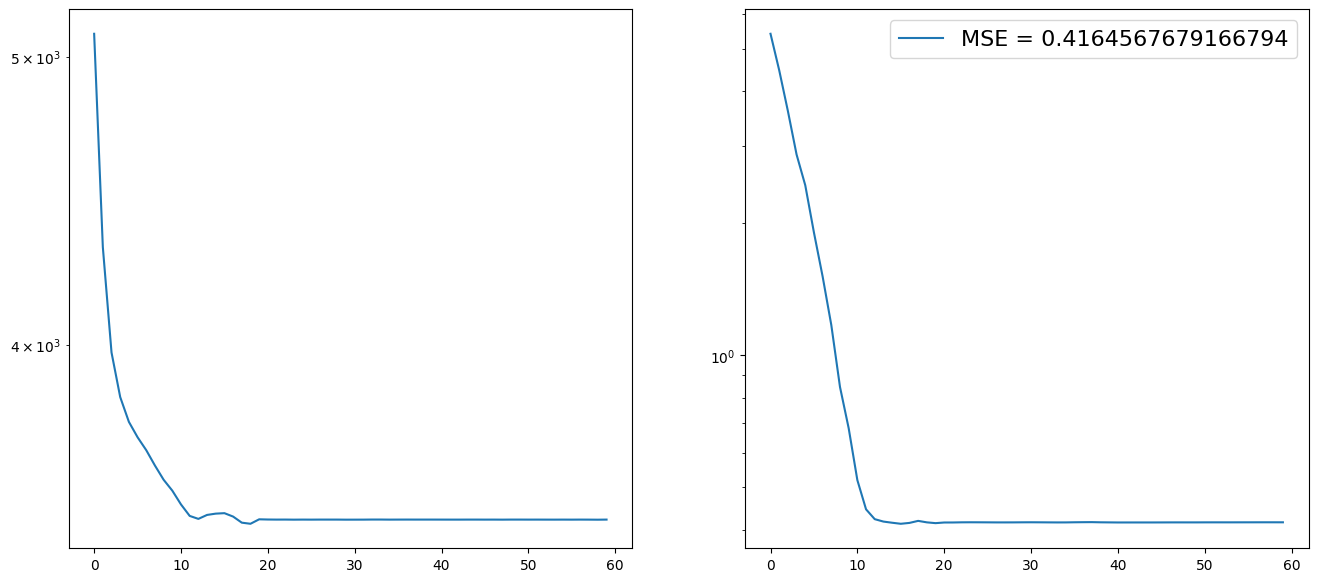

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

dataset_with_embeddings = Embeddings(dataset, 2)

ref_model = Hawkes(100, 1.0, 0.35, 0.7)
model = TransformerHawkes(2,2,2,2,1)
batch_size = 100

train_dataloader = torch.utils.data.DataLoader(dataset_with_embeddings, batch_size = batch_size, num_workers = 0, pin_memory = True, shuffle = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.1)

losses = []
mse_lambdas = []

for epoch in range(60):
  clear_output(wait=True)
  l,m = train(model, ref_model, train_dataloader, optimizer, epoch)
  losses.append(l)
  mse_lambdas.append(m)
  scheduler.step()

  fig, axes = plt.subplots(1, 2, figsize=(16,7))
  axes[0].plot(losses)
  axes[0].set_yscale('log')
  axes[1].plot(mse_lambdas, label = "MSE = {}".format(m))
  axes[1].set_yscale('log')
  axes[1].legend(fontsize=16, loc="upper right", bbox_to_anchor=(1,1))
  plt.show()


#### Вопрос - что нужно поменять, чтобы мы могли работать с последовательностями из нескольких типов событий разной длины?

- Нам нужно добавить типы событий в датасет ```self.event_types```, проверить, что у нас нет событий типа 0, который мы будем использовать как padding, иначе сдвинуть типы событий (```self.event_types += 1```).
- Нужно добавить ```nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)``` и добавить выход из данного слоя к временному представлению.
- Нужно использовать zero padding с помощью функции ```torch.nn.functional.pad```, чтобы учесть последовательности разных времен в трансформере.
- Нужно изменить
```
self.alpha = Parameter(torch.ones(1))
self.w  = Parameter(torch.rand(M))
self.b = Parameter(torch.ones(1))
```
на
```
self.alpha = Parameter(torch.ones(n_types))
self.w  = Parameter(torch.rand(M,n_types))
self.b = Parameter(torch.ones(n_types))
```
и использовать соответствующую функцию интенсивности в $\sum \log \lambda_{c_i}(t_i)$


Вместо того, чтобы реализовывать данную модель руками, можно использовать следующую реализацию https://github.com/SimiaoZuo/Transformer-Hawkes-Process

### Эксперименты с реальными данными

Для реальных примеров мы сравним модель Neural Hawkes с моделью Hawkes.



#### Neural Hawkes

https://github.com/xiao03/nh

#### Загрузка данных

Прежде всего, мы должны загрузить данные, которые мы будем использовать для обучения.

In [ ]:
!pip install googledrivedownloader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1i3NI7zKjaTzrPLi1IPVWAiFjXjch8oc2',
                                    dest_path='./train.pkl')

gdd.download_file_from_google_drive(file_id='1q1VUY3VTmaZqT8VjWY5hKrSx8v9tZbt7',
                                    dest_path='./train_tick.pkl')

Это набор данных твитов с историей действий твитов. Давайте откроем файл.

In [ ]:
!pip install pickle-mixin --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=6006 sha256=4fe56530c680545d8e4abb8b3acacc7bb995a20cfc4d1c73ad6e88f9717677e7
  Stored in directory: /root/.cache/pip/wheels/58/c6/8b/061bd4edc8cea2b2235758c3e50473d08499236fbfdd21e6b3
Successfully built pickle-mixin


In [ ]:
import pickle
with open('./train.pkl','rb') as f:
  train_dset = pickle.load(f)

In [ ]:
train_dset.keys()

dict_keys([b'test1', b'args', b'dim_process', b'dev', b'train', b'test'])

In [ ]:
train_dset[b'train'][0]

[{b'time_since_start': 15.0, b'time_since_last_event': 15.0, b'type_event': 1},
 {b'time_since_start': 16.0, b'time_since_last_event': 1.0, b'type_event': 1},
 {b'time_since_start': 19.0, b'time_since_last_event': 3.0, b'type_event': 1},
 {b'time_since_start': 23.0, b'time_since_last_event': 4.0, b'type_event': 1},
 {b'time_since_start': 23.0, b'time_since_last_event': 0.0, b'type_event': 0},
 {b'time_since_start': 25.0, b'time_since_last_event': 2.0, b'type_event': 1},
 {b'time_since_start': 28.0, b'time_since_last_event': 3.0, b'type_event': 0},
 {b'time_since_start': 30.0, b'time_since_last_event': 2.0, b'type_event': 0},
 {b'time_since_start': 32.0, b'time_since_last_event': 2.0, b'type_event': 0},
 {b'time_since_start': 33.0, b'time_since_last_event': 1.0, b'type_event': 0},
 {b'time_since_start': 34.0, b'time_since_last_event': 1.0, b'type_event': 0},
 {b'time_since_start': 36.0, b'time_since_last_event': 2.0, b'type_event': 0},
 {b'time_since_start': 39.0, b'time_since_last_even

Здесь нам нужен только ключ  'train'; 'test', 'dev' и 'test1' пусты, эти данные в других файлах. Dev — это проверочный набор данных, мы его тоже загрузим.

Количество типов событий равно трем.

In [ ]:
train_dset[b'dim_process']

3

#### Neural Hawkes

##### Функции утилит

`generate_sim_time_seqs` позволяет нам генерировать время для интегрального вычисления MC. Sim_index_seq — это вспомогательная последовательность для вычисления затухания скрытого состояния.

In [22]:
import torch

def generate_sim_time_seqs(time_seqs, seqs_length):
    """Generate a simulated time interval sequences from original time interval sequences based on uniform distribution

    Args:
        time_seqs: list of torch float tensors
    Results:
        sim_time_seqs: list of torch float tensors
        sim_index_seqs: list of torch long tensors
    """
    sim_time_seqs = torch.zeros((time_seqs.size()[0], time_seqs.size()[1]-1)).float()
    sim_index_seqs = torch.zeros((time_seqs.size()[0], time_seqs.size()[1]-1)).long()
    restore_time_seqs, restore_sim_time_seqs = [], []
    for idx, time_seq in enumerate(time_seqs):
        restore_time_seq = torch.stack([torch.sum(time_seq[0:i]) for i in range(1,seqs_length[idx]+1)])
        restore_sim_time_seq, _ = torch.sort(torch.empty(seqs_length[idx]-1).uniform_(0, restore_time_seq[-1]))

        sim_time_seq = torch.zeros(seqs_length[idx]-1)
        sim_index_seq = torch.zeros(seqs_length[idx]-1).long()

        for idx_t, t in enumerate(restore_time_seq):
            indices_to_update = restore_sim_time_seq > t

            sim_time_seq[indices_to_update] = restore_sim_time_seq[indices_to_update] - t
            sim_index_seq[indices_to_update] = idx_t

        restore_time_seqs.append(restore_time_seq)
        restore_sim_time_seqs.append(restore_sim_time_seq)
        sim_time_seqs[idx, :seqs_length[idx]-1] = sim_time_seq
        sim_index_seqs[idx, :seqs_length[idx]-1] = sim_index_seq

    return sim_time_seqs, sim_index_seqs

`pad_bos` функция позволяет дополнять последовательности, а также добавляет дополнительное нулевое событие, запускающее последовательность.

In [23]:
def pad_bos(batch_data, type_size):
    event_seqs, time_seqs, total_time_seqs, seqs_length = batch_data
    pad_event_seqs = torch.zeros((event_seqs.size()[0], event_seqs.size()[1]+1)).long() * type_size
    pad_time_seqs = torch.zeros((time_seqs.size()[0], event_seqs.size()[1]+1)).float()

    pad_event_seqs[:, 1:] = event_seqs.clone()
    pad_event_seqs[:, 0] = type_size
    pad_time_seqs[:, 1:] = time_seqs.clone()

    return pad_event_seqs, pad_time_seqs, total_time_seqs, seqs_length

##### Датасет

In [24]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader

class CTLSTMDataset(Dataset):
    ''' Dataset class for neural hawkes data
    '''
    def __init__(self, file_path):
        self.file_path = file_path
        self.event_seqs = []
        self.time_seqs = []

        with open(self.file_path, 'rb') as f:
            if 'dev' in file_path:
                seqs = pickle.load(f)[b'dev']
            elif 'train' in file_path:
                seqs = pickle.load(f)[b'train'][:1000] # crop
            for idx, seq in enumerate(seqs):
                # if idx == 1:
                #     print(seq[0].keys())
                self.event_seqs.append(torch.LongTensor([int(event[b'type_event']) for event in seq]))
                self.time_seqs.append(torch.FloatTensor([float(event[b'time_since_last_event']) for event in seq]))

    def __len__(self):
        return len(self.event_seqs)

    def __getitem__(self, index):
        sample = {
            'event_seq': self.event_seqs[index],
            'time_seq': self.time_seqs[index]
        }

        return sample

def pad_batch_fn(batch_data):
    sorted_batch = sorted(batch_data, key=lambda x: x['event_seq'].size(), reverse=True)
    event_seqs = [seq['event_seq'].long() for seq in sorted_batch]
    time_seqs = [seq['time_seq'].float() for seq in sorted_batch]
    seqs_length = torch.LongTensor(list(map(len, event_seqs)))
    last_time_seqs = torch.stack([torch.sum(time_seq) for time_seq in time_seqs])

    event_seqs_tensor = torch.zeros(len(sorted_batch), seqs_length.max()).long()
    time_seqs_tensor = torch.zeros(len(sorted_batch), seqs_length.max()).float()

    for idx, (event_seq, time_seq, seqlen) in enumerate(zip(event_seqs, time_seqs, seqs_length)):
        event_seqs_tensor[idx, :seqlen] = torch.LongTensor(event_seq)
        time_seqs_tensor[idx, :seqlen] = torch.FloatTensor(time_seq)

    return event_seqs_tensor, time_seqs_tensor, last_time_seqs, seqs_length

##### Модель

In [25]:
"""A continuous time LSTM network."""
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader


class CTLSTM(nn.Module):
    """Continuous time LSTM network with decay function."""
    def __init__(self, hidden_size, type_size, batch_first=True):
        super(CTLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.type_size = type_size
        self.batch_first = batch_first
        self.num_layers = 1

        # Parameters
        # recurrent cells
        self.rec = nn.Linear(2*self.hidden_size, 7*self.hidden_size)
        # output mapping from hidden vectors to unnormalized intensity
        self.wa = nn.Linear(self.hidden_size, self.type_size)
        # embedding layer for valid events, including BOS
        self.emb = nn.Embedding(self.type_size+1, self.hidden_size)

    def init_states(self, batch_size):
        self.h_d = torch.zeros(batch_size, self.hidden_size, dtype=torch.float)
        self.c_d = torch.zeros(batch_size, self.hidden_size, dtype=torch.float)
        self.c_bar = torch.zeros(batch_size, self.hidden_size, dtype=torch.float)
        self.c = torch.zeros(batch_size, self.hidden_size, dtype=torch.float)

    def recurrence(self, emb_event_t, h_d_tm1, c_tm1, c_bar_tm1):
        feed = torch.cat((emb_event_t, h_d_tm1), dim=1)
        # B * 2H
        (gate_i,
        gate_f,
        gate_z,
        gate_o,
        gate_i_bar,
        gate_f_bar,
        gate_delta) = torch.chunk(self.rec(feed), 7, -1)

        gate_i = torch.sigmoid(gate_i)
        gate_f = torch.sigmoid(gate_f)
        gate_z = torch.tanh(gate_z)
        gate_o = torch.sigmoid(gate_o)
        gate_i_bar = torch.sigmoid(gate_i_bar)
        gate_f_bar = torch.sigmoid(gate_f_bar)
        gate_delta = F.softplus(gate_delta)

        c_t = gate_f * c_tm1 + gate_i * gate_z
        c_bar_t = gate_f_bar * c_bar_tm1 + gate_i_bar * gate_z

        return c_t, c_bar_t, gate_o, gate_delta

    def decay(self, c_t, c_bar_t, o_t, delta_t, duration_t):
        c_d_t = c_bar_t + (c_t - c_bar_t) * \
            torch.exp(-delta_t * duration_t.view(-1,1))

        h_d_t = o_t * torch.tanh(c_d_t)

        return c_d_t, h_d_t

    def forward(self, event_seqs, duration_seqs, batch_first = True):
        if batch_first:
            event_seqs = event_seqs.transpose(0,1)
            duration_seqs = duration_seqs.transpose(0,1)

        batch_size = event_seqs.size()[1]
        batch_length = event_seqs.size()[0]

        h_list, c_list, c_bar_list, o_list, delta_list = [], [], [], [], []
        self.init_states(batch_size)
        for t in range(batch_length):
            c, self.c_bar, o_t, delta_t = self.recurrence(self.emb(event_seqs[t]), self.h_d, self.c_d, self.c_bar)
            self.c_d, self.h_d = self.decay(c, self.c_bar, o_t, delta_t, duration_seqs[t])
            h_list.append(self.h_d)
            c_list.append(c)
            c_bar_list.append(self.c_bar)
            o_list.append(o_t)
            delta_list.append(delta_t)
        h_seq = torch.stack(h_list)
        c_seq = torch.stack(c_list)
        c_bar_seq = torch.stack(c_bar_list)
        o_seq = torch.stack(o_list)
        delta_seq = torch.stack(delta_list)

        self.output = torch.stack((h_seq, c_seq, c_bar_seq, o_seq, delta_seq))
        return self.output

    def log_likelihood(self, event_seqs, sim_time_seqs, sim_index_seqs, total_time_seqs, seqs_length, batch_first=True):
        """Calculate log likelihood per sequence."""
        batch_size, batch_length = event_seqs.shape
        h, c, c_bar, o, delta = torch.chunk(self.output, 5, 0)
        # L * B * H
        h = torch.squeeze(h, 0)
        c = torch.squeeze(c, 0)
        c_bar = torch.squeeze(c_bar, 0)
        o = torch.squeeze(o, 0)
        delta = torch.squeeze(delta, 0)

        # Calculate the sum of log intensities of each event in the sequence
        original_loglikelihood = torch.zeros(batch_size)
        lambda_k = F.softplus(self.wa(h)).transpose(0, 1)

        for idx, (event_seq, seq_len) in enumerate(zip(event_seqs, seqs_length)):
            original_loglikelihood[idx] = torch.sum(torch.log(
                                                     lambda_k[idx, torch.arange(seq_len).long(), event_seq[1:seq_len+1]]))

        # Calculate simulated loss from MCMC method
        h_d_list = []
        if batch_first:
            sim_time_seqs = sim_time_seqs.transpose(0,1)
        for idx, sim_duration in enumerate(sim_time_seqs):
            _, h_d_idx = self.decay(c[idx], c_bar[idx], o[idx], delta[idx], sim_duration)
            h_d_list.append(h_d_idx)
        h_d = torch.stack(h_d_list)

        sim_lambda_k = F.softplus(self.wa(h_d)).transpose(0,1)
        simulated_likelihood = torch.zeros(batch_size)
        for idx, (total_time, seq_len) in enumerate(zip(total_time_seqs, seqs_length)):
            mc_coefficient = total_time / (seq_len)
            simulated_likelihood[idx] = mc_coefficient * torch.sum(torch.sum(sim_lambda_k[idx, torch.arange(seq_len).long(), :]))

        loglikelihood = torch.sum(original_loglikelihood - simulated_likelihood)
        return loglikelihood

##### Обучение

In [ ]:
import time
import datetime
import torch
import torch.optim as opt
from torch.utils.data import DataLoader

def train(hidden_size, type_size, train_path, batch_size, epoch_num, current_date):
    """Training process."""
    model = CTLSTM(hidden_size, type_size)
    optim = opt.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 10, 0.5)
    train_dataset = CTLSTMDataset(train_path)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=pad_batch_fn, shuffle=True)

    last_dev_loss = 0.0
    for epoch in range(epoch_num):
        tic_epoch = time.time()
        epoch_train_loss = 0.0
        epoch_dev_loss = 0.0
        train_event_num = 0
        dev_event_num = 0
        print('Epoch.{} starts.'.format(epoch))
        tic_train = time.time()
        for i_batch, sample_batched in enumerate(train_dataloader):
            tic_batch = time.time()

            optim.zero_grad()

            event_seqs, time_seqs, total_time_seqs, seqs_length = pad_bos(sample_batched, model.type_size)

            sim_time_seqs, sim_index_seqs = generate_sim_time_seqs(time_seqs, seqs_length)

            model.forward(event_seqs, time_seqs)
            likelihood = model.log_likelihood(event_seqs, sim_time_seqs, sim_index_seqs, total_time_seqs, seqs_length)
            batch_event_num = torch.sum(seqs_length)
            batch_loss = -likelihood

            batch_loss.backward()
            optim.step()
            scheduler.step()

            toc_batch = time.time()
            if i_batch % 1 == 0:
                print('Epoch.{} Batch.{}:\nBatch Likelihood per event: {:5f} nats\nTrain Time: {:2f} s'.format(epoch, i_batch, likelihood/batch_event_num, toc_batch-tic_batch))
            epoch_train_loss += batch_loss
            train_event_num += batch_event_num

        toc_train = time.time()
        print('---\nEpoch.{} Training set\nTrain Likelihood per event: {:5f} nats\nTrainig Time:{:2f} s'.format(epoch, -epoch_train_loss/train_event_num, toc_train-tic_train))

    return

In [ ]:
train(128, 3, './train.pkl' ,100, 10, '28.03.2022')

Epoch.0 starts.
Epoch.0 Batch.0:
Batch Likelihood per event: -5187.104004 nats
Train Time: 4.352528 s
Epoch.0 Batch.1:
Batch Likelihood per event: -4422.440430 nats
Train Time: 4.490039 s
Epoch.0 Batch.2:
Batch Likelihood per event: -4368.797363 nats
Train Time: 3.820288 s
Epoch.0 Batch.3:
Batch Likelihood per event: -3403.154297 nats
Train Time: 4.290802 s
Epoch.0 Batch.4:
Batch Likelihood per event: -3183.195801 nats
Train Time: 4.329916 s
Epoch.0 Batch.5:
Batch Likelihood per event: -2516.318848 nats
Train Time: 4.436917 s
Epoch.0 Batch.6:
Batch Likelihood per event: -2283.875732 nats
Train Time: 4.266607 s
Epoch.0 Batch.7:
Batch Likelihood per event: -1741.562134 nats
Train Time: 4.542661 s
Epoch.0 Batch.8:
Batch Likelihood per event: -1711.052124 nats
Train Time: 4.263375 s
Epoch.0 Batch.9:
Batch Likelihood per event: -1160.349121 nats
Train Time: 4.647866 s
---
Epoch.0 Training set
Train Likelihood per event: -2968.340332 nats
Trainig Time:43.484316 s
Epoch.1 starts.
Epoch.1 Batc

# home quize

In [3]:
!gdown 1mzI7d7or-tWumaccvTcZForIfrn9qSdz

Downloading...
From: https://drive.google.com/uc?id=1mzI7d7or-tWumaccvTcZForIfrn9qSdz
To: /content/data_so.zip
100% 41.3M/41.3M [00:01<00:00, 28.5MB/s]


In [ ]:
!unzip data_so.zip

In [ ]:
!ls data_so_coh

In [12]:
from glob import glob
import pandas as pd
from tqdm import tqdm

In [13]:
data_list = []
for i in tqdm(glob('data_so_coh/*csv')):
  data_list.append(pd.read_csv(i))
df = pd.concat(data_list)

print(df.shape)
df.head(1)

100%|██████████| 33166/33166 [00:46<00:00, 714.86it/s]


(2435235, 6)


,Unnamed: 0,time,delta_time,event,sequence_id,cluster_id
0,0,1325.708618,0.0,3.0,NaN,NaN


In [ ]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],

    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

In [ ]:
..